In [260]:
#import library
import os
import numpy as np
import scipy.io
import pandas as pd
from scipy import signal
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from mne.decoding import CSP
from sklearn.metrics import accuracy_score
import mne
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

#filePath = '/Users/yamamotokouhei/subjectsData/data20221122'
#filePath = '/Users/yamamotokouhei/subjectsData/braindata20221003'
#filePath = '/Users/kyamamoto/Desktop/けんきゅうしつ/実験データ/20230208_zzikken'
#filepath= '/Users/yaman/Library/CloudStorage/GoogleDrive-s203192@stn.nagaokaut.ac.jp/マイドライブ/実験データ/20230214_zikken'
filepath= '/Users/yaman/Library/CloudStorage/GoogleDrive-s203192@stn.nagaokaut.ac.jp/マイドライブ/実験データ/20230208_zzikken'
#filePath = '/Users/yaman/Library/CloudStorage/GoogleDrive-s203192@stn.nagaokaut.ac.jp/マイドライブ/20230214_zikken'
#
#filepath = '/Users/yaman/brain_data/20230214_zikken'

brainAdress = ['Fp1','AF7','AF3','F1','F3','F5','F7','FT7','FC5',
'FC3','FC1','C1','C3','C5','T7','TP7','CP5','CP3','CP1','P1','P3',
'P5','P7','P9','PO7','PO3','O1','Iz','Oz','POz','Pz','CPz','Fpz','Fp2',
'AF8','AF4','AFz','Fz','F2','F4','F6','F8','FT8','FC6','FC4','FC2',
'FCz','Cz','C2','C4','C6','T8','TP8','CP6','CP4','CP2','P2','P4',
'P6','P8','P10','PO8','PO4','O2']

# dataクラス
class O_Data:
    def __init__(self, eeg, index, label):
        self.eeg = eeg
        self.index = index
        self.label = label
        self.stack = []

    def push(self, item):
        self.stack.append(item)

o_data65_label1 = list()#label1のデータ
o_data65_label2 = list()#label2のデータ
o_data = list()
label_data = list()#labelを結合したデータ

file_name = list()  # すべての.matファイルの名前
for file in os.listdir(filepath):
    base, ext = os.path.splitext(file)
    if ext == '.mat':
        file_name = sorted(file_name)
        file_name.append(file)
print('Filelist')
print(file_name)

Filelist
['EEG_grasping_08-Feb-2023_sub1-1.mat', 'EEG_grasping_08-Feb-2023_sub1-2.mat', 'EEG_grasping_08-Feb-2023_sub1-3.mat', 'EEG_grasping_08-Feb-2023_sub2-1.mat', 'EEG_grasping_08-Feb-2023_sub2-2.mat', 'EEG_grasping_08-Feb-2023_sub2-3.mat', 'EEG_grasping_08-Feb-2023_sub3-1.mat', 'EEG_grasping_08-Feb-2023_sub3-2.mat', 'EEG_grasping_08-Feb-2023_sub3-3.mat', 'EEG_grasping_08-Feb-2023_sub4-2.mat', 'EEG_grasping_08-Feb-2023_sub4-3.mat', 'EEG_grasping_08-Feb-2023_sub5-1.mat', 'EEG_grasping_08-Feb-2023_sub5-2.mat', 'EEG_grasping_08-Feb-2023_sub5-3.mat', 'EEG_grasping_08-Feb-2023_sub4-1.mat']


In [261]:
#label1の設定
file_name1 = [file_name[0],file_name[1],file_name[2]]
file_num1 = len(file_name1)
print(file_name1)
#label2の設定
file_name2 = [file_name[6],file_name[7],file_name[8]]
file_num2 = len(file_name2)
print(file_name2)
# 変数など
trial_num = 30
all_trial = (len(file_name1)+len(file_name2))* trial_num
all_d = 0
CH = 64
#label1を読み込む
for s in range(file_num1):
    Dictionary = scipy.io.loadmat(filepath+"/"+file_name1[s])
    for t in range(trial_num):
        for i, key in enumerate(Dictionary.keys()):
            if i > 2:
                a = Dictionary[key]
                b = a[0, t][0][0]
                eeg = b[0][0:64, :]
                index = b[1]
                samplerate = b[2]
                label = b[5][0, 0]
                o_data = O_Data(eeg, index, label)
                o_data65_label1.append(o_data)
#label2を読み込む
for s in range(file_num2):
    Dictionary = scipy.io.loadmat(filepath+"/"+file_name2[s])
    for t in range(trial_num):
        for i, key in enumerate(Dictionary.keys()):
            if i > 2:
                a = Dictionary[key]
                b = a[0, t][0][0]
                eeg = b[0][0:64, :]
                index = b[1]
                samplerate = b[2]
                label = b[5][0, 0]
                o_data = O_Data(eeg, index, label)
                o_data65_label2.append(o_data)
print("data_loading")

['EEG_grasping_08-Feb-2023_sub1-1.mat', 'EEG_grasping_08-Feb-2023_sub1-2.mat', 'EEG_grasping_08-Feb-2023_sub1-3.mat']
['EEG_grasping_08-Feb-2023_sub3-1.mat', 'EEG_grasping_08-Feb-2023_sub3-2.mat', 'EEG_grasping_08-Feb-2023_sub3-3.mat']
data_loading


In [262]:
c1 = o_data65_label1[0].eeg[: , 0:8100]
c2 = o_data65_label2[0].eeg[: , 0:8100]
for n in range(len(file_name1)*trial_num-1):  # all_trial
    g1 = o_data65_label1[n+1].eeg[: , 0:8100]
    g2 = o_data65_label2[n+1].eeg[: , 0:8100]
    c1 = np.dstack([c1, g1])
    c2 = np.dstack([c2, g2])

In [263]:
all_data = np.dstack([c1, c2])
all_data = all_data.transpose(2,0,1)
print(np.shape(all_data))
all_data = all_data.astype(np.double)

(180, 64, 8100)


In [264]:
def baseline_mod(data,rest):
    data_count=len(data)
    x_data = np.arange(data_count)
    x = np.arange(rest*1024)
    theta_1 = np.cov(x,data[0:rest*1024])[0][1]/np.var(x)
    theta_0 = np.mean(data[0:rest*1024]) - theta_1*np.mean(x)
    base = theta_0 + theta_1*x_data
    data_base_fit = data - base
    return data_base_fit

In [265]:
def lowpass(x, samplerate, fp, fs, gpass, gstop):
    fn = samplerate / 2                           #ナイキスト周波数
    wp = fp / fn                                  #ナイキスト周波数で通過域端周波数を正規化
    ws = fs / fn                                  #ナイキスト周波数で阻止域端周波数を正規化
    N, Wn = signal.buttord(wp, ws, gpass, gstop)  #オーダーとバターワースの正規化周波数を計算
    b, a = signal.butter(N, Wn, "low")            #フィルタ伝達関数の分子と分母を計算
    y = signal.filtfilt(b, a, x)                  #信号に対してフィルタをかける
    return y 

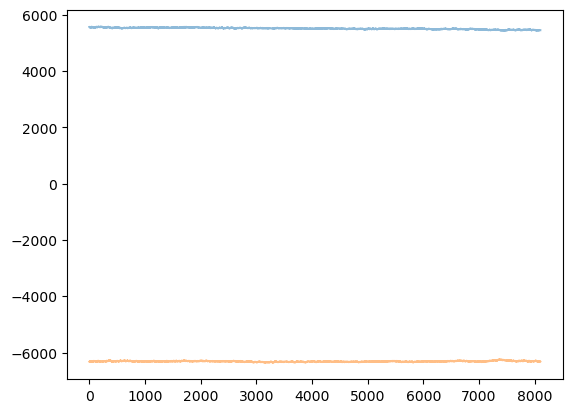

In [266]:
plt.plot(all_data[0][0],label= 'moving slow',alpha=0.5)
plt.plot(all_data[90][0],label= 'moving fast',alpha=0.5)
plt.show()

In [267]:
for i in range(180):
    for j in range(64):
        all_data[i][j] = lowpass(all_data[i][j],1024,30,80,3,40)
        all_data[i][j] = baseline_mod(all_data[i][j],2)
        all_data[i][j] = scipy.stats.zscore(all_data[i][j])

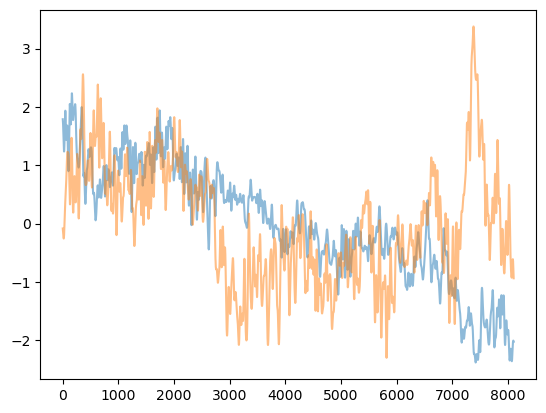

In [268]:
plt.plot(all_data[0][0],label= 'moving slow',alpha=0.5)
plt.plot(all_data[90][0],label= 'moving fast',alpha=0.5)
plt.show()

In [269]:
#ラベル生成
label = np.zeros(180,dtype=int)
label[90:] = 1
# a = list()
# b = list() 
# for n in range(len(file_name1)*trial_num):  # all_trial
#     label1 = o_data65_label1[n].label
#     # if label1 == 2:
#     #     label1 = 0
#     # if label2 == 2:
#     #     label2 = 0
#     a.append(label1)
# for n in range(len(file_name2)*trial_num):  # all_trial
#     label2 = o_data65_label2[n].label
#     b.append(label2)
# label = a+b
# print(a)
# print(b)

print(label)
label = np.array(label)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [270]:
data_label1 = np.zeros((64,8100))
data_label2 = np.zeros((64,8100))
data_label1 = all_data[0:90]
data_label2 = all_data[90:180]
print(np.shape(data_label1))
print(np.shape(data_label2))

(90, 64, 8100)
(90, 64, 8100)


In [271]:
nsamples, nx, ny = all_data.shape
d2_train_dataset = all_data.reshape((nsamples,nx*ny))
np.shape(d2_train_dataset)

(180, 518400)

In [272]:
X_train, X_test, Y_train, Y_test = train_test_split(d2_train_dataset, label, test_size=0.25,random_state=42)
simple_model =SVC(kernel='linear')
scores = cross_val_score(simple_model, X_test, Y_test)
simple_model.fit(X_train,Y_train)
test_label = simple_model.predict(X_test)
print("accuracy=",accuracy_score(test_label,Y_test))

# print('Cross-Validation scores: {}'.format(scores))
# # スコアの平均値
# print('Average score: {}'.format(np.mean(scores)))

accuracy= 0.6888888888888889


In [ ]:
import numpy as np
from scipy import fftpack
def calc_fft(data, samplerate):
    spectrum = fftpack.fft(data)                                     # 信号のフーリエ変換
    amp = np.sqrt((spectrum.real ** 2) + (spectrum.imag ** 2))       # 振幅成分
    amp = amp / (len(data) / 2)                                      # 振幅成分の正規化（辻褄合わせ）
    phase = np.arctan2(spectrum.imag, spectrum.real)                 # 位相を計算
    phase = np.degrees(phase)                                        # 位相をラジアンから度に変換
    freq = np.linspace(0, samplerate, len(data))                     # 周波数軸を作成
    return spectrum, amp, phase, freq

In [ ]:
samplerate = 1024
for n in range(180):  # all_channel
    for i in range(64):  # all_channel
        spectrum, amp, phase, freq = calc_fft(data_label1[n][i], samplerate)

In [273]:
all_indices = list(range(all_trial))
sub, main = train_test_split(all_indices, test_size=0.6,random_state=42)
#print(main)
train = all_data[sub,:,:]
test = all_data[main,:,:]
train_label = label[sub]
test_label = label[main]
print(np.shape(train))
print(np.shape(test))
# print(sub)
# print(main)
# print(train_label)
# print(test_label)

(72, 64, 8100)
(108, 64, 8100)


In [274]:
# Assemble a classifier
lda = LinearDiscriminantAnalysis()
#csp = CSP(n_components=2, log=None, reg=None)
csp = CSP(n_components=4, reg=None, norm_trace=False, transform_into='average_power')
# Use scikit-learn Pipeline with cross_val_score function

In [275]:
n_channels = 64
sampling_freq = 1024  # in Hertz
info = mne.create_info(ch_names=brainAdress, ch_types="eeg", sfreq=sampling_freq)
info.set_montage('biosemi64')

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 1024.0 Hz
>

Computing rank from data with rank=None
    Using tolerance 41 (2.2e-16 eps * 64 dim * 2.9e+15  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 43 (2.2e-16 eps * 64 dim * 3e+15  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 41 (2.2e-16 eps * 64 dim * 2.9e+15  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 43 (2.2e-16 eps * 64 dim * 3e+15  max singular value)
    Estimated rank (mag)

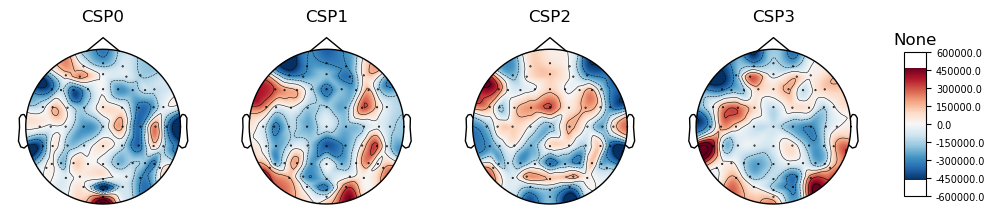

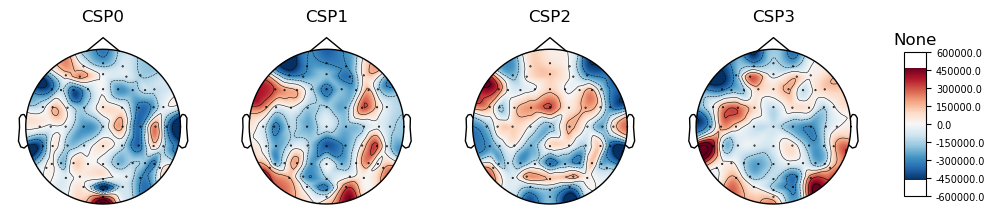

In [276]:
# Printing the results
class_balance = np.mean(train_label == train_label[0])
class_balance = max(class_balance, 1. - class_balance)
#print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),class_balance))

# plot CSP patterns estimated on full data for visualization
kenshou = csp.fit_transform(train, train_label)
csp.fit_transform(train, train_label)
csp.plot_patterns(info,ch_type='eeg', units='None', size=1.5)

In [277]:
print(np.shape(kenshou))

(72, 4)


In [278]:
basac = csp.transform(test)
print(np.shape(basac))


(108, 4)


In [279]:
#X_train, X_test, Y_train, Y_test = train_test_split(basac, test_label, test_size=0.2,random_state=42)
model =SVC(kernel='linear')
scores = cross_val_score(model, basac, test_label,cv=5)
model.fit(kenshou,train_label)
print(model.score(kenshou, train_label))
print(model.score(basac, test_label))


print('Cross-Validation scores: {}'.format(scores))
# スコアの平均値
print('Average score: {}'.format(np.mean(scores)))

1.0
0.6944444444444444
Cross-Validation scores: [0.5        0.90909091 0.72727273 0.61904762 0.71428571]
Average score: 0.6939393939393941


In [280]:
# # 境界線プロット用の格子状データを生成
# x1 = np.linspace(0.0, 10.0, 100)
# x2 = np.linspace(0.0, 10.0, 100)
# X1, X2 = np.meshgrid(x1, x2)    
# plot_X = np.c_[X1.ravel(), X2.ravel()]

# plot_y = model.predict(plot_X)

# # 検証結果の表示
# print("plot X：", plot_X)
# print("plot y：", plot_y)

# グラフ設定
#plt.figure(figsize=(10, 10))
# # 格子データで散布図をプロットし、決定境界を描画（y=0:blue, y=1:red）
# plt.scatter(plot_X.T[0][plot_y <= 0], plot_X.T[1][plot_y <= 0], marker='o', color="blue", alpha=0.2)
# plt.scatter(plot_X.T[0][plot_y > 0], plot_X.T[1][plot_y > 0], marker='o', color="red", alpha=0.2)

# # 学習用データを散布図にプロット（y=0:blue, y=1:red）
# plt.scatter(kenshou.T[0][train_label <= 0], kenshou.T[1][train_label <= 0], marker='o', color="blue", alpha=1.0,label = "slow")
# plt.scatter(kenshou.T[0][train_label > 0], kenshou.T[1][train_label > 0], marker='o', color="red", alpha=1.0,label = "fast")
# plt.legend()
# plt.xlabel('x1')            # x軸ラベル
# plt.ylabel('x2')            # y軸ラベル
# # plt.xlim(-4, 4)
# # plt.ylim(-4, 4)
# plt.show()


In [281]:
# from mlxtend.plotting import plot_decision_regions
# plot_decision_regions(basac, test_label, clf=model)
# plt.xlabel('x1')            # x軸ラベル
# plt.ylabel('x2')
# # plt.xlim(-5, 4)
# # plt.ylim(-5, 2)
# plt.show()